In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt  # ✅ Make sure this is included


In [46]:
# Define dataset path
data_dir = "rice_leaf_diseases"  # Ensure your dataset is in this directory with subfolders per class

In [ ]:
# Image transformations (resize, normalize, convert to tensor)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])


In [48]:
# Load dataset
dataset = ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes  # Get class labels

In [49]:
# Create a DataLoader for visualization
dataloader = DataLoader(dataset, batch_size=6, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7490196..0.8980392].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..0.8352941].


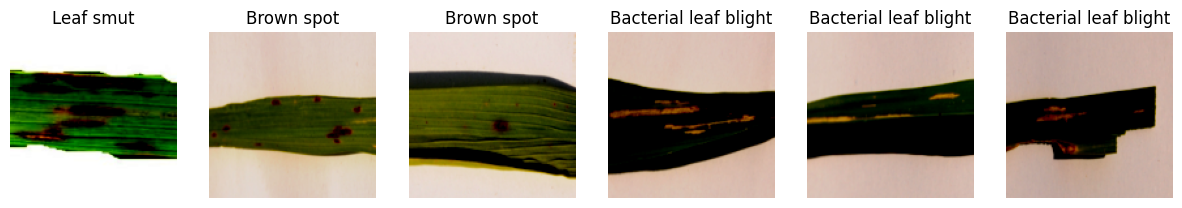

In [50]:
# Get a batch of images
data_iter = iter(dataloader)
images, labels = next(data_iter)

# Convert images to NumPy format for display
fig, axes = plt.subplots(1, 6, figsize=(15, 5))

for i in range(6):
    img = images[i].permute(1, 2, 0).numpy()  # Convert (C, H, W) to (H, W, C)
    axes[i].imshow(img)
    axes[i].set_title(class_names[labels[i].item()])
    axes[i].axis("off")

plt.show()


In [51]:
# Split dataset into training and testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [52]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Classes: {class_names}")

Classes: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


Train Model


In [53]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [54]:
# Define CNN model
class RiceDiseaseCNN(nn.Module):
    def __init__(self):
        super(RiceDiseaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, len(class_names))  # Output layer
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 32 * 32 * 32)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model
model = RiceDiseaseCNN()

In [55]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [56]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")

Epoch 1/100, Loss: 1.2391
Epoch 2/100, Loss: 0.9121
Epoch 3/100, Loss: 0.7131
Epoch 4/100, Loss: 0.5580
Epoch 5/100, Loss: 0.4557
Epoch 6/100, Loss: 0.3341
Epoch 7/100, Loss: 0.2175
Epoch 8/100, Loss: 0.1346
Epoch 9/100, Loss: 0.0806
Epoch 10/100, Loss: 0.0363
Epoch 11/100, Loss: 0.0205
Epoch 12/100, Loss: 0.0098
Epoch 13/100, Loss: 0.0068
Epoch 14/100, Loss: 0.0044
Epoch 15/100, Loss: 0.0034
Epoch 16/100, Loss: 0.0033
Epoch 17/100, Loss: 0.0024
Epoch 18/100, Loss: 0.0018
Epoch 19/100, Loss: 0.0015
Epoch 20/100, Loss: 0.0013
Epoch 21/100, Loss: 0.0011
Epoch 22/100, Loss: 0.0010
Epoch 23/100, Loss: 0.0008
Epoch 24/100, Loss: 0.0008
Epoch 25/100, Loss: 0.0007
Epoch 26/100, Loss: 0.0006
Epoch 27/100, Loss: 0.0005
Epoch 28/100, Loss: 0.0005
Epoch 29/100, Loss: 0.0004
Epoch 30/100, Loss: 0.0004
Epoch 31/100, Loss: 0.0004
Epoch 32/100, Loss: 0.0003
Epoch 33/100, Loss: 0.0003
Epoch 34/100, Loss: 0.0003
Epoch 35/100, Loss: 0.0002
Epoch 36/100, Loss: 0.0002
Epoch 37/100, Loss: 0.0002
Epoch 38/1

Model Evaluation

In [57]:
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 75.00%
